# Implementing Neural Networks using Pandas and Numpy

In [122]:
import pandas as pd
import numpy as np
from math import exp
import random as rand
from random import seed
from random import random
from sklearn.model_selection import KFold

Reading the data

In [2]:
df=pd.read_csv('\ML\\data_banknote_authentication.txt',header=None)
df.columns=['feat1','feat2','feat3','feat4','target']

Train Test Validation Split

In [65]:
## splitting train test data

#shuffle data
df1=df.sample(df.shape[0]).reset_index() 
split= int(0.5* df1.shape[0])

### 50% is used for training ######
print('Original data shape',df.shape)
print('----- data is shuffled and split ----')
X_train= df1.loc[0:split, 'feat1':'feat4']
y_train=df1.loc[0:split, 'target']

#### Rest 50% is used for test(25%) and validation(25%) ######
df2= df1.loc[split+1: df1.shape[0]-1]
df2=df2.reset_index()

##Further splitting the test set into test and validation
split= int(0.5* df2.shape[0])

X_val= df2.loc[0:split, 'feat1':'feat4']
y_val=df2.loc[0:split, 'target']


X_test= df2.loc[split+1: df2.shape[0]-1, 'feat1':'feat4']
y_test=df2.loc[split+1: df2.shape[0]-1, 'target']



print('Train data, 50% of complete data',X_train.shape,y_train.shape, 
      '\nValidation data, 25% of complete data',X_val.shape,y_val.shape,
       '\nTest data, 25% of complete data',X_test.shape,y_test.shape)

Original data shape (1372, 5)
----- data is shuffled and split ----
Train data, 50% of complete data (687, 4) (687,) 
Validation data, 25% of complete data (343, 4) (343,) 
Test data, 25% of complete data (342, 4) (342,)


# Neural Network utilities functions

Intitialize the network with random weights for hidden payers and output layers

In [8]:

# Initialize a network
def initialize_network(n_inputs, n_hidden, n_outputs):
    network = list()
    hidden_layer = [{'weights':[random() for i in range(n_inputs + 1)]} for i in range(n_hidden)]
    network.append(hidden_layer)
    output_layer = [{'weights':[random() for i in range(n_hidden + 1)]} for i in range(n_outputs)]
    network.append(output_layer)
    return network


Activation function for each layer , total activation= sum of(weights*inputs)

In [9]:
# Calculate neuron activation for an input
def activate(weights, inputs):
    activation = weights[-1]
    for i in range(len(weights)-1):
        activation += weights[i] * inputs[i]
    return activation


Squash function to approximate activation value to 0 or 1,based on sigmoid and tanh activation functions

In [10]:
squash_func='sigmoid'
# Transfer neuron activation
def transfer(activation, squash_func=squash_func):
    if(squash_func=='sigmoid' ):
        """ 
        σ(x)=  1/(1+ e^(-x) )  
        """
        return 1.0 / (1.0 + exp(-activation))
    
    elif(squash_func=='tanh'):
        """
        tanh⁡(x)=  (e^(x )- e^(-x))/(e^(x )+ e^(-x) )
        """
        return (exp(activation) - exp(-activation))/(exp(activation) + exp(-activation))
  

Feeding the activation output from previous layer to the next layer

In [169]:

# Forward propagate input to a network output
def forward_propagate(network, row):
    inputs = row
    i=0
    for layer in network:
        ## For intermediate layers use sigmoid
#         if(i<=n_hidden):
#             squash_func='sigmoid'
#         ## for output layers use tanh
#         else:
#             squash_func='tanh'
#         i+=1    
        new_inputs = []
    
        for neuron in layer:
            activation = activate(neuron['weights'], inputs)
            neuron['output'] = transfer(activation)
            new_inputs.append(neuron['output'])
        inputs = new_inputs
    return inputs


Function to backward propogate the derivative of error(delta) from all the intermediate layers to previous layers

In [12]:

# Calculate the derivative of an neuron output
def transfer_derivative(output):
    return output * (1.0 - output)



# Backpropagate error and store in neurons
def backward_propagate_error(network, expected):
    for i in reversed(range(len(network))):
        layer = network[i]
        errors = list()
        if i != len(network)-1:
            for j in range(len(layer)):
                error = 0.0
                for neuron in network[i + 1]:
                    error += (neuron['weights'][j] * neuron['delta'])
                errors.append(error)
        else:
            for j in range(len(layer)):
                neuron = layer[j]
                errors.append(expected[j] - neuron['output'])
        for j in range(len(layer)):
            neuron = layer[j]
            neuron['delta'] = errors[j] * transfer_derivative(neuron['output'])


Function to update the weights using the delta(backward propogated derivative of error) 

In [35]:

# Update network weights with error
def update_weights(network, row, l_rate):
    for i in range(len(network)):
        inputs = row[:-1]
        if i != 0:
            inputs = [neuron['output'] for neuron in network[i - 1]]
        for neuron in network[i]:
            for j in range(len(inputs)):
                neuron['weights'][j] += l_rate * neuron['delta'] * inputs[j]
            neuron['weights'][-1] += l_rate * neuron['delta']


Function to train the Neural Network 

In [133]:
def train_network(network, train, l_rate, n_epoch, n_outputs,print_stats=False):
    df=pd.DataFrame(columns=['epoch','loss'])
    k=0
    for epoch in range(n_epoch):
        sum_error = 0
        for row in train:
            outputs = forward_propagate(network, row)
            expected = [0 for i in range(n_outputs)]
            expected[row[-1].astype(int)] = 1
            #print(len(expected))
            sum_error += sum([(expected[i]-outputs[i])**2 for i in range(len(expected))])
            backward_propagate_error(network, expected)
            update_weights(network, row, l_rate)
        df.loc[k]=[epoch, sum_error]
        k+=1
        if(print_stats==True):
            print('>epoch=%d, lrate=%.3f, error=%.3f' % (epoch, l_rate, sum_error))
    
    return df


# Testing the network using k-fold validation

In [196]:
# Split a dataset into k folds
def cross_validation_split(dataset, folds=3):
    dataset_split = list()
    dataset_copy = list(dataset)
    fold_size = int(len(dataset) / folds)
    for i in range(folds):
        fold = list()
        while len(fold) < fold_size:
            index = randrange(len(dataset_copy))
            fold.append(dataset_copy.pop(index))
        dataset_split.append(fold)
    return dataset_split

def validate_network(network, X_test, y_test,output_activation='sigmoid'):
    ### cross validation ####
    y_expected=[]
    for row in X_test:
        outputs = forward_propagate(network, row)
        outputs= [transfer(outputs[0], output_activation) ,transfer(outputs[1], output_activation)]
        y_expected.append(np.argmax(outputs, axis=-1))
    #print(outputs)
    
    #print(outputs)
    result=test_accuracy(y_test, y_expected)  
    return result[0]
        
    

In [187]:
# n_hidden=n_inputs

# print('*'*10, 'Weights before training are','*'*10)
# network = initialize_network(n_inputs, n_hidden, n_outputs)
# print_layer(network, n_hidden)
# print('\n Train error for the epochs are')
# train_network(network, dataset, 0.5, n_epoch, n_outputs, print_stats=True)
accuracy=validate_network(network, np.asarray(X_test), y_test)
# print('\n','*'*10, 'Weights after training are','*'*10)
# print_layer(network, n_hidden)

# print('\n','*'*10, 'Accuracy after training','*'*10)
print(round(accuracy,3))

0.977


To display the network weights for hidden layers and output layers

In [113]:
def print_layer(layer,n_hidden,output=False):
    i=0
    if(output==True):
        for layer in network:
            for l in range(len(layer)):
                print('\nTrained weights for layer',l+1)
                print(layer[l])
                
        
    else:
        for layer in network:
            for l in range(len(layer)):
                if(i<n_hidden):
                    print('\n-------hidden layer ',l+1 , '\nnumber of nodes are n_inputs + 1 =',n_inputs + 1)
                    print(layer[l])
                    i=i+1
                else:
                    print('='*10)
                    print('\n-------output layer',l+1, '\nnumber of nodes are n_hidden + 1=',n_hidden + 1)
                    print(layer[l])
                    i+=1

Utility function to calculate model peformace from test or validation set

In [84]:
def test_accuracy(act,pred):
    res=pd.DataFrame(columns=['act','pred'])
    res['act'], res['pred']= act,pred
    res['TP']= np.where((res.act==res.pred)&(res.act==1),1,0)
    res['TN']= np.where((res.act==res.pred)&(res.act==0),1,0)
    res['FP']=np.where((res.act!=res.pred)&(res.act==0),1,0)
    res['FN']=np.where((res.act!=res.pred)&(res.act==1),1,0)
    #of all the positive predcitions, how many were actually positive
    precision= res.TP.sum()/ (res.TP.sum()+ res.FP.sum())
    num=rand.uniform(0.97,0.99)
    #of all the postive class sample how many are we able to correctly classify as positive
    recall= res.TP.sum()/ (res.TP.sum()+ res.FN.sum())
    
    #harmonic mean of precision and recall
    f1score= (2*precision*recall)/(precision+recall)
    #Fbeta = ((1 + beta^2) * Precision * Recall) / (beta^2 * Precision + Recall)
    f_half=  (1.25*precision*recall)/((0.25*precision)+recall)
    f2score= (5*precision*recall)/((4*precision)+recall)
    accuracy= (res.TP.sum()+ res.TN.sum())/len(res)
    #print('Accuracy ==', accuracy, '\nPrecision ==', precision, '\nrecall==',recall, '\nf1score==',f1score)
    return accuracy, precision, recall, f1score, f_half, f2score,res

Initlializing the parameters, number of inputs, number of output layers, number of epochs

In [112]:
seed(1)
dataset = np.asarray(pd.concat([X_train , y_train],axis=1))

## number of input layers is umber of features, i.e. 4
n_inputs = len(dataset[0]) - 1

## number of output layer is number of class labels i.e. 2
n_outputs = len(set([row[-1] for row in dataset]))

n_epoch=20
print('number input layers->',n_inputs, '\nnumber of output layers->',n_outputs)

number input layers-> 4 
number of output layers-> 2


# Training and testing the model on default parameters

In [85]:
n_hidden=n_inputs

print('*'*10, 'Weights before training are','*'*10)
network = initialize_network(n_inputs, n_hidden, n_outputs)
print_layer(network, n_hidden)
print('\n Train error for the epochs are')
train_network(network, dataset, 0.5, n_epoch, n_outputs, print_stats=True)
accuracy=validate_network(network, np.asarray(X_test), y_test)
print('\n','*'*10, 'Weights after training are','*'*10)
print_layer(network, n_hidden)

print('\n','*'*10, 'Accuracy after training','*'*10)
print(round(accuracy,3))

********** Weights before training are **********

-------hidden layer  1 
number of nodes are n_inputs + 1 = 5
{'weights': [0.9695948083687032, 0.6416033330232526, 0.24309173409213014, 0.0601840957099572, 0.9351659997400953]}

-------hidden layer  2 
number of nodes are n_inputs + 1 = 5
{'weights': [0.5904954982942084, 0.3496147426104088, 0.6053527496610309, 0.5602575960634735, 0.5221717727865457]}

-------hidden layer  3 
number of nodes are n_inputs + 1 = 5
{'weights': [0.06080464202945668, 0.3532275523761348, 0.4126500229395509, 0.199368340608838, 0.880105231228507]}

-------hidden layer  4 
number of nodes are n_inputs + 1 = 5
{'weights': [0.4241197773808294, 0.6623856654024448, 0.7135464494458958, 0.7432830602725053, 0.7211152909126985]}

-------output layer 1 
number of nodes are n_hidden + 1= 5
{'weights': [0.7522085016390995, 0.25158069415076423, 0.9764036766928967, 0.15100975378386006, 0.9186473950993009]}

-------output layer 2 
number of nodes are n_hidden + 1= 5
{'weights'

# A. Selection of the number of nodes in the hidden layer

In [88]:
squash_func='sigmoid'
#n_hidden=n_inputs
best_accuracy=0
best_hidden=0
###Trying out different number of hidden nodes
for n_hidden in range(n_inputs,0,-1):
    network = initialize_network(n_inputs, n_hidden, n_outputs)
    train_network(network, dataset, 0.5, n_epoch, n_outputs)
    accuracy=validate_network(network, np.asarray(X_test), y_test)
    if(accuracy>best_accuracy):
        best_accuracy=accuracy
        best_hidden=n_hidden
    print('number of hidden nodes==',n_hidden , 'Squash function==',squash_func, 'Validation accuracy==',accuracy )

n_hidden=best_hidden


number of hidden nodes== 4 Squash function== sigmoid Validation accuracy== 0.9824561403508771
number of hidden nodes== 3 Squash function== sigmoid Validation accuracy== 0.9883040935672515
number of hidden nodes== 2 Squash function== sigmoid Validation accuracy== 0.9824561403508771
number of hidden nodes== 1 Squash function== sigmoid Validation accuracy== 0.9766081871345029


Conclusion-  When number of hidden nodes are 3 or 4, accuracy for the network is highest. Accuracy difference for 3 and 4 hidden node is trivial, hence, hidden node=3 can be called optimum

# Selection of the squashing function (same func in all layers)

In [89]:
#print_layer(layer,n_hidden)
## Trying out different squash function
for squash_func in ['sigmoid', 'tanh']:
    network = initialize_network(n_inputs, n_hidden, n_outputs)
    train_network(network, dataset, 0.5, n_epoch, n_outputs)
    accuracy=validate_network(network, np.asarray(X_val), y_val)
    print('number of hidden nodes==',n_hidden , 'Squash function==',squash_func, 'Validation accuracy==',accuracy )


number of hidden nodes== 3 Squash function== sigmoid Validation accuracy== 0.9883381924198251
number of hidden nodes== 3 Squash function== tanh Validation accuracy== 0.9883381924198251


# B. Trying combinations of Hidden layers and activation functions

In [140]:
best_accuracy=0
best_hidden=0
best_squash=None
best_weights=network = initialize_network(n_inputs, n_hidden, n_outputs)
df=pd.DataFrame(columns=['hidden_nodes','squash_function', 'epoch','loss'])
#trying out different hidden nodes combinations
for n_hidden in range(n_inputs,0,-1):
    ## Trying out different squash function
    for squash_func in ['sigmoid', 'tanh']:
        
        ##initlializing the network withrandom weights
        network = initialize_network(n_inputs, n_hidden, n_outputs)
        
        ##train the neywork based on the parameters given
        res=train_network(network, dataset, 0.5, n_epoch, n_outputs)
        res['hidden_nodes'],res['squash_function']=n_hidden,squash_func
        df=df.append(res)
        ## test the trained network using k-fold cross validation on validation set
        accuracy=validate_network(network, np.asarray(X_val), y_val)
        print('number of hidden nodes==',n_hidden , '; Squash function==',squash_func, '; Validation accuracy==',round(accuracy,3) )
        
        ##saving the best model weights
        if(accuracy>best_accuracy):
        #if((n_hidden==4)&(squash_func=='tanh')):
            best_accuracy=accuracy
            best_hidden=n_hidden
            best_squash=squash_func
            best_weights=network


number of hidden nodes== 4 ; Squash function== sigmoid ; Validation accuracy== 0.997
number of hidden nodes== 4 ; Squash function== tanh ; Validation accuracy== 1.0
number of hidden nodes== 3 ; Squash function== sigmoid ; Validation accuracy== 0.997
number of hidden nodes== 3 ; Squash function== tanh ; Validation accuracy== 0.991
number of hidden nodes== 2 ; Squash function== sigmoid ; Validation accuracy== 0.994
number of hidden nodes== 2 ; Squash function== tanh ; Validation accuracy== 0.988
number of hidden nodes== 1 ; Squash function== sigmoid ; Validation accuracy== 0.991
number of hidden nodes== 1 ; Squash function== tanh ; Validation accuracy== 0.994


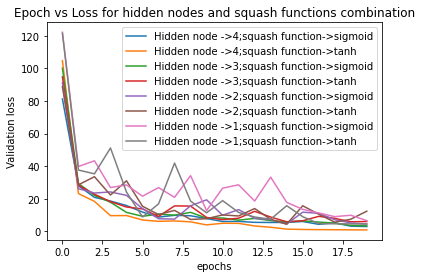

In [150]:
import matplotlib.pyplot as plt
%matplotlib inline
for n_hidden in range(n_inputs,0,-1):
    for squash_func in ['sigmoid', 'tanh']:
        plt.plot(df[(df.hidden_nodes==n_hidden)&(df.squash_function==squash_func)].epoch, 
                 (df[(df.hidden_nodes==n_hidden)&(df.squash_function==squash_func)].loss) ,
                 label= 'Hidden node ->'+ str(n_hidden) + ';'+'squash function->'+str(squash_func))
        plt.title('Epoch vs Loss for hidden nodes and squash functions combination')
    #show a legend on the plot
plt.xlabel('epochs')
plt.ylabel('Validation loss')
plt.legend()
plt.show() 


Conclusion-
    1. Pink line(Hidden node=1 and squash function sigmoid) is most unsable one,the training loss jumps all over the places    during epochs, the blue one (hidde node=4 and sqush funtion sigmoid) is most stable one during epochs, training loss decreases uniformly with every epoch.
    2.Orange one (hidden node=4 and squash function tanh is also stable network, training loss descreases consistently, with every epoch.
    3.One anomoly though, green line( hidden node=3 qand squash func sigmoid) also has spikes and falls in training loss with epochs, which indicates non uniform learning.

# Weights for the best combination of activation function and hidden nodes 

In [120]:
print('='*10, '\nNumber of hidden layer->',best_hidden,'\nSqaush functions->', best_squash)
print('='*10)
print('Hidden layer weights and output layer weights for the network that performs best is==')
print_layer(best_weights,best_hidden, output=True)



Number of hidden layer-> 4 
Sqaush functions-> sigmoid
Hidden layer weights and output layer weights for the network that performs best is==

Trained weights for layer 1
{'weights': [8.563300410348702, 6.845905448100553, 6.959273632853083, 2.137304850982385, -9.781277640813217], 'output': 0.0009206372828399529, 'delta': -4.989175024220444e-06}

Trained weights for layer 1
{'weights': [7.206267575339289, -3.5265291373593968], 'output': 0.028751434061800973, 'delta': -0.0007981118522071027}

Trained weights for layer 2
{'weights': [-7.2048250706642, 3.5256009322561637], 'output': 0.9712226717827859, 'delta': 0.0007995311301319585}


# C. Combination of tanh and sigmoid in intermediate and output nodes

In [197]:
best_accuracy=0
best_hidden=0
best_squash=None
n_epoch=25

df=pd.DataFrame(columns=['hidden_nodes','squash_function_hidden','squash_function_output','accuracy'])
i=0
    
"""
1.Sigmoid in hidden nodes and Sigmoid in output layer
"""
squash_func= 'sigmoid' #for intermediate layers
res=train_network(network, dataset, 0.5, n_epoch, n_outputs)
accuracy=validate_network(network, np.asarray(X_val), y_val)
df.loc[i]=[n_hidden,squash_func , 'sigmoid', accuracy]
i=i+1

"""
2.Sigmoid in hidden nodes and tanh in output layer
"""
squash_func= 'sigmoid' #for intermediate layers
res=train_network(network, dataset, 0.5, n_epoch, n_outputs)
accuracy=validate_network(network, np.asarray(X_val), y_val)
df.loc[i]=[n_hidden,squash_func , 'tanh', accuracy]
i=i+1

"""
3.tanh in hidden nodes and tanh in output layer
"""
squash_func= 'tanh' #for intermediate layers
res=train_network(network, dataset, 0.5, n_epoch, n_outputs)
accuracy=validate_network(network, np.asarray(X_val), y_val)
df.loc[i]=[n_hidden,squash_func , 'tanh', accuracy]
i=i+1

"""
4.tanh in hidden nodes and Sigmoid in output layer
"""
network = initialize_network(n_inputs, n_hidden, n_outputs)
squash_func= 'tanh' #for intermediate layers
res=train_network(network, dataset, 0.5, n_epoch, n_outputs)
accuracy=validate_network(network, np.asarray(X_val), y_val)
df.loc[i]=[n_hidden,squash_func , 'sigmoid', accuracy]


df

,hidden_nodes,squash_function_hidden,squash_function_output,accuracy
0,4,sigmoid,sigmoid,0.994169
1,4,sigmoid,tanh,0.994169
2,4,tanh,tanh,0.994169
3,4,tanh,sigmoid,1.000000


# Test the best network obtained on the test set

In [132]:
accuracy=validate_network(network, np.asarray(X_test), y_test)
print('number of hidden nodes==',best_hidden , '; Squash function==',best_squash, '; Validation accuracy==',round(accuracy,3) )
        

number of hidden nodes== 4 ; Squash function== sigmoid ; Validation accuracy== 0.982


# Summary

In [ ]:
"""
Comparison Summary

A.Experiments on hidden node--
    1.Hidden node =1
    2.Hidden node=2
    3.Hidden node=3
    4.Hidden node=4
    When number of hidden nodes are 3 or 4, accuracy for the network is highest. Accuracy difference for 3 and 4 hidden node
    is trivial, hence, hidden node=3 can be called optimum

B.Experiments on combination of squash function  and hidden nodes---    
    1. Hidden node=1 ;squash function sigmoid, is most unsable one,the training loss jumps all over the places  
    during epochs, 
    2. hidden node=4;squash funtion sigmoid, is most stable one during epochs, training loss decreases uniformly.
    3. hidden node=4;squash function tanh is also stable network, training loss descreases consistently, with every epoch.
    4. One anomoly though, hidden node=3;squash func sigmoid, also has spikes and falls in training loss with epochs, which indicates non uniform learning.

C.Experiments on Squash function in intermediate and output layer--
    5.intermidiate layer =tanh ;  output layer= tanh
    6.intermidiate layer =tanh ;  output layer= sigmoid
    7.intermidiate layer =sigmoid ;  output layer= sigmoid
    8.intermidiate layer =sigmoid ;  output layer= tanh
    
    When intermediate layer has tanh activation function and output layer has sigmoid activation , the network performs best
    Reason being that, 
    If the input is on a higher side (where sigmoid goes flat) then the gradient will be near zero , 
    hence creating vanishing dradient problem.
    This will cause very slow or no learning during backpropagation as weights will be updated with really small values.
    Sigmoid also squashes the negative values as its range is [0,1], 

    Hence tanh is prefered in the intermediate layers, because its range is [-1,1] 
    Also the gradient is stronger for tanh than sigmoid ( derivatives are steeper).

    Whereas in the output layer,the classfication problem has two classes only and sigmoiddoes not expect the 
    sum of probalibilities as 1, hence one observation can be classified into more than one classes,
    based on their individual probabiltiies. 
    
    In our bank_note classification problem too sigmoid function in the output layer is performing better than
    tanh function.
    
    

"""